In [ ]:
import pandas as pd
from google.colab import files

# Upload all files first
uploaded = files.upload()

Saving global_olive_oil_price.csv to global_olive_oil_price (5).csv
Saving olive_production.csv to olive_production (6).csv
Saving tunisian_olive_oil_prices.csv to tunisian_olive_oil_prices (6).csv


In [ ]:
import pandas as pd
from google.colab import files

def load_data():
    # Global prices (monthly)
    global_price = pd.read_csv('global_olive_oil_price.csv', parse_dates=['Year'])
    global_price.rename(columns={'POLVOILUSDM': 'Global_Price_USD_per_tonne'}, inplace=True)

    # Tunisian prices (monthly)
    tunisian_price = pd.read_csv('tunisian_olive_oil_prices.csv')

    # Production (yearly)
    production = pd.read_csv('olive_production.csv')

    # Trade data (yearly) - Manually entered data
    trade_data = {
        'Year': [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                 2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,
                 2020,2021,2022,2023],
        'Exports': [2271629349.0,2272874413.0,2669718640.0,3515493168.0,4579627019.0,
                    5181435857.0,6162135683.0,6020705949.0,6321468170.0,5305058017.0,
                    5566944900.0,6104667370.0,5805682224.0,7058407466.0,7203528778.0,
                    7684995384.0,7685665718.0,8437997027.0,8720385729.0,7378381590.0,
                    7917069343.0,8821532012.0,10316547666.0,11878554001.0],
        'Imports': [13776.0,50400.0,183627.0,134534.0,245250.0,
                    866148.0,3789083.0,2399885.0,1583027.0,689879.0,
                    827335.0,653982.0,642898.0,988369.0,4553749.0,
                    1658898.0,12978872.0,6589306.0,1730654.0,2751791.0,
                    1245341.0,1538275.0,1169022.0,4752652.0]
    }
    trade_df = pd.DataFrame(trade_data)

    return global_price, tunisian_price, production, trade_df

def process_tunisian_prices(df):
    # Convert Price column to string so that .str methods can be applied,
    # then remove any spaces and replace commas with dots before converting to float.
    df['Price'] = df['Price'].astype(str).str.replace(' ', '').str.replace(',', '.').astype(float)

    # Convert French month abbreviations to English abbreviations for datetime parsing.
    month_translation = {
        'janv.': 'Jan', 'févr.': 'Feb', 'mars': 'Mar', 'avr.': 'Apr',
        'mai': 'May', 'juin': 'Jun', 'juil.': 'Jul', 'août': 'Aug',
        'sept.': 'Sep', 'oct.': 'Oct', 'nov.': 'Nov', 'déc.': 'Dec'
    }
    df['Year'] = df['Year'].replace(month_translation, regex=True)
    df['Date'] = pd.to_datetime(df['Year'], format='%b %Y', errors='coerce')

    # Rename the price column to indicate it is per liter
    return df[['Date', 'Price']].rename(columns={'Price': 'Tunisian_Price_TND_per_liter'})

def convert_global_price(df, exchange_rates):
    # Extract year from the datetime column
    df['year'] = df['Year'].dt.year
    # Map the corresponding exchange rate (TND per USD) for each year
    df['exchange_rate'] = df['year'].map(exchange_rates)

    # Conversion factor: 1 metric tonne = 1091.74 liters
    df['Global_Price_TND_per_liter'] = (df['Global_Price_USD_per_tonne'] * df['exchange_rate']) / 1091.74

    # Drop temporary columns used for calculation
    df.drop(columns=['year', 'exchange_rate'], inplace=True)

    return df

def main():
    # Load all datasets
    global_price, tunisian_price, production, trade_df = load_data()

    # Process Tunisian prices and rename the price column properly
    tunisian_price = process_tunisian_prices(tunisian_price)

    # Resample global prices to monthly data (averaging if multiple observations exist in a month)
    global_price = global_price.resample('M', on='Year').mean().reset_index()

    # Populate exchange rate dictionary (TND per USD) for each year
    exchange_rates = {
        1990: 1.8,
        1991: 1.8,
        1992: 1.8,
        1993: 1.8,
        1994: 1.8,
        1995: 1.8,
        1996: 1.8,
        1997: 1.8,
        1998: 1.8,
        1999: 1.8,
        2000: 1.8,
        2001: 1.8,
        2002: 1.8,
        2003: 1.8,
        2004: 1.8,
        2005: 1.8,
        2006: 1.8,
        2007: 1.8,
        2008: 1.8,
        2009: 1.8,
        2010: 1.8,
        2011: 1.8,
        2012: 1.8,
        2013: 1.8,
        2014: 1.8,
        2015: 1.8,
        2016: 2.0,
        2017: 2.1,
        2018: 2.2,
        2019: 2.3,
        2020: 2.4,
        2021: 2.5,
        2022: 2.6,
        2023: 2.7,
        2024: 2.8
    }

    # Convert global price to TND per liter using year-specific exchange rates
    global_price = convert_global_price(global_price, exchange_rates=exchange_rates)

    # Create a base monthly DataFrame from January 1990 to December 2024
    all_months = pd.date_range(start='1990-01-01', end='2024-12-31', freq='M')
    df = pd.DataFrame({'Date': all_months})
    df['Year-Month'] = df['Date'].dt.to_period('M')
    df['year'] = df['Date'].dt.year

    # --- Merge monthly datasets (global and Tunisian prices) on Year-Month ---
    for dataset, date_col in [(global_price, 'Year'), (tunisian_price, 'Date')]:
        dataset['Year-Month'] = dataset[date_col].dt.to_period('M')
        df = df.merge(dataset.drop(columns=[date_col]), on='Year-Month', how='left')

    # --- Merge yearly datasets (production and trade) based on year ---
    # For production data
    production['year'] = pd.to_datetime(production['Year'], format='%Y').dt.year
    df = df.merge(production.drop(columns=['Year']), on='year', how='left')
    # For trade data: replicate each year's exports and imports across all months in that year
    trade_df['year'] = pd.to_datetime(trade_df['Year'], format='%Y').dt.year
    df = df.merge(trade_df.drop(columns=['Year']), on='year', how='left')

    # Forward-fill production if needed (in case of missing monthly values)
    df['production(1000Tonne)'] = df['production(1000Tonne)'].ffill()

    # Sort and finalize the DataFrame, then drop helper columns
    df = df.sort_values('Date')
    df.drop(columns=['Year-Month', 'year'], inplace=True)

    # Optionally, rename trade columns
    df = df.rename(columns={
        'Exports': 'Monthly_Exports',
        'Imports': 'Monthly_Imports'
    })

    # Save the final CSV file
    df.to_csv('combined_olive_data.csv', index=False)
    files.download('combined_olive_data.csv')

if __name__ == '__main__':
    main()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

# Upload all files first
uploaded = files.upload()

Saving draft1_oliveoil.csv to draft1_oliveoil.csv


In [ ]:
import pandas as pd

# Load the CSV file with a different delimiter (try ';' or '\t' if it's not a comma)
file_path = 'draft1_oliveoil.csv'  # Adjust the path if needed
df = pd.read_csv(file_path, encoding='ISO-8859-1', delimiter=';')  # Adjust delimiter if necessary

# Ensure that the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter the data between 30th June 2010 and 31st December 2023
start_date = '2015-01-31'
end_date = '2023-12-31'

# Filter the DataFrame using boolean indexing
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Check the filtered data
print(filtered_df)

# Optionally, save the filtered data to a new CSV file
filtered_df.to_csv('filtered_olive_data.csv', index=False)

# To download the filtered file in Colab
from google.colab import files
files.download('filtered_olive_data.csv')


          Date  Global_Price_USD_per_tonne  Global_Price_TND_per_liter  \
300 2015-01-31                 4128.513119                    6.806862   
301 2015-02-28                 4169.564192                    6.874545   
302 2015-03-31                 3933.601822                    6.485503   
303 2015-04-30                 3996.582960                    6.589343   
304 2015-05-31                 4305.325946                    7.098381   
..         ...                         ...                         ...   
403 2023-08-31                 9034.554858                   22.343505   
404 2023-09-30                 9364.941141                   23.160589   
405 2023-10-31                 9145.115742                   22.616935   
406 2023-11-30                 8891.228564                   21.989042   
407 2023-12-31                 9468.728560                   23.417267   

    Tunisian_Price_TND_per_liter  Variation  Yearly_production(1000Tonne)  \
300                     7 883,20  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from google.colab import files

# Upload all files first
uploaded = files.upload()

Saving olive.csv to olive.csv


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import pandas as pd

# Load data with corrected parameters
df = pd.read_csv(
    'olive.csv',
    sep=';',
    decimal=',',  # Use comma as decimal separator
    thousands=' ',  # Use space as thousand separator
    parse_dates=['Date'],  # Parse dates directly
    dayfirst=True  # Ensure day-first format (e.g., 30/06/2010)
)
df.set_index('Date', inplace=True)  # Set date as index

# No need for manual string replacement! pandas already parsed the column as float.
df.head()

,Global_Price_USD_per_tonne,Global_Price_TND_per_liter,Tunisian_Price_TND_per_liter,Variation,Yearly_production(1000Tonne),Yearly_Exports,Yearly_Imports
Date,,,,,,,
2015-01-31,4128.51311936364,6.806862086993746,7883.20,"2,09%",1700.0,7684995384.0,1658898.0
2015-02-28,4169.5641918,6.874544804843644,8047.85,"-4,36%",1700.0,7684995384.0,1658898.0
2015-03-31,3933.60182154545,6.485503213935378,7696.58,"1,80%",1700.0,7684995384.0,1658898.0
2015-04-30,3996.58296040909,6.589343001755328,7835.11,"6,29%",1700.0,7684995384.0,1658898.0
2015-05-31,4305.3259462381,7.098381210937202,8328.27,"1,31%",1700.0,7684995384.0,1658898.0


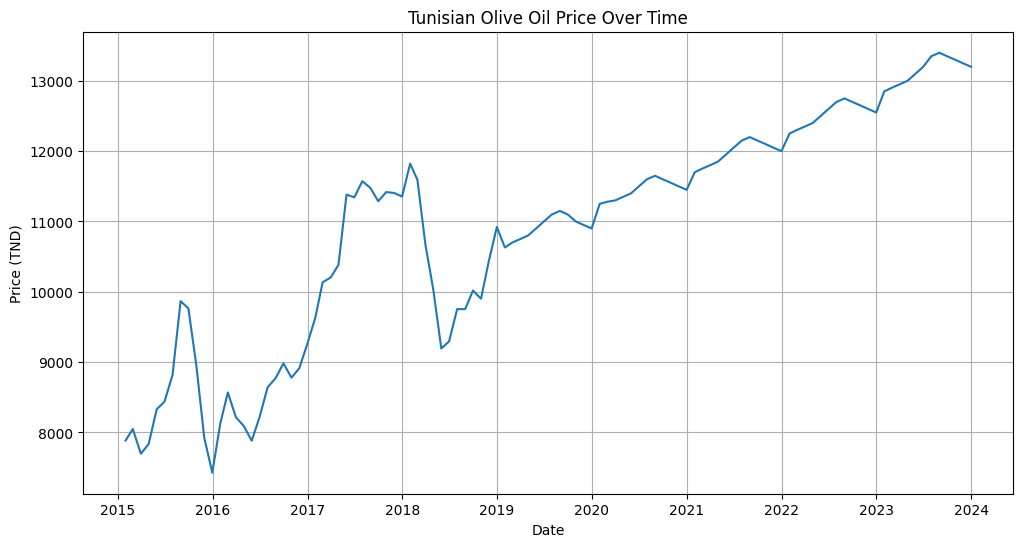

,Global_Price_USD_per_tonne,Global_Price_TND_per_liter,Tunisian_Price_TND_per_liter,Variation,Yearly_production(1000Tonne),Yearly_Exports,Yearly_Imports,Tunisian_Price_diff
Date,,,,,,,,
2015-01-31,4128.51311936364,6.806862086993746,7883.20,"2,09%",1700.0,7684995384.0,1658898.0,NaN
2015-02-28,4169.5641918,6.874544804843644,8047.85,"-4,36%",1700.0,7684995384.0,1658898.0,164.65
2015-03-31,3933.60182154545,6.485503213935378,7696.58,"1,80%",1700.0,7684995384.0,1658898.0,-351.27
2015-04-30,3996.58296040909,6.589343001755328,7835.11,"6,29%",1700.0,7684995384.0,1658898.0,138.53
2015-05-31,4305.3259462381,7.098381210937202,8328.27,"1,31%",1700.0,7684995384.0,1658898.0,493.16


In [ ]:
# Plot the Tunisian price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Tunisian_Price_TND_per_liter'], label='Price (TND/L)')
plt.title('Tunisian Olive Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (TND)')
plt.grid(True)
plt.show()
df.head()

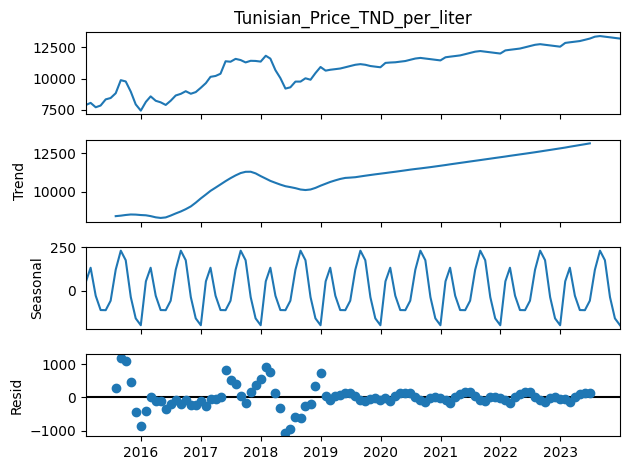

In [ ]:
# Decompose into trend, seasonality, and residuals
decomposition = seasonal_decompose(df['Tunisian_Price_TND_per_liter'], model='additive', period=12)
decomposition.plot()
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
result = adfuller(df['Tunisian_Price_TND_per_liter'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# If p-value > 0.05, the series is non-stationary and needs differencing.

ADF Statistic: -0.41926639925615433
p-value: 0.9068319400130123


In [ ]:
# Apply differencing
df['Tunisian_Price_diff'] = df['Tunisian_Price_TND_per_liter'].diff().dropna()

# Re-run ADF test on differenced data
result_diff = adfuller(df['Tunisian_Price_diff'].dropna())
print(f'ADF Statistic (Differenced): {result_diff[0]}')
print(f'p-value (Differenced): {result_diff[1]}')

ADF Statistic (Differenced): -4.982779390336087
p-value (Differenced): 2.4002285818831735e-05


In [ ]:
df_clean = df.dropna(subset=['Tunisian_Price_diff'])

In [ ]:
train_diff = df_clean['Tunisian_Price_diff'].iloc[:-12]  # Last 12 months for testing
test_diff = df_clean['Tunisian_Price_diff'].iloc[-12:]

In [ ]:
# Fit model
model = SARIMAX(train_diff, order=(0,0,1), seasonal_order=(2,0,0,12))
model_fit = model.fit()

In [ ]:
# Forecast
forecast_diff = model_fit.get_forecast(steps=12).predicted_mean

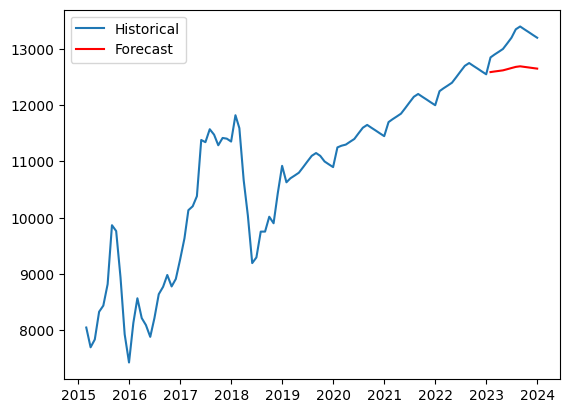

In [ ]:
# Reverse differencing
last_price = df_clean['Tunisian_Price_TND_per_liter'].iloc[-len(test_diff)-1]
forecast_prices = last_price + forecast_diff.cumsum()

# Plot
plt.plot(df_clean.index, df_clean['Tunisian_Price_TND_per_liter'], label='Historical')
plt.plot(test_diff.index, forecast_prices, label='Forecast', color='red')
plt.legend()
plt.show()